In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Data loading and preprocessing
dataset = pd.read_csv("Regression.csv").drop(columns=["station", "Date"]).dropna()
X, Y = dataset.iloc[:, :-2], dataset.iloc[:, -2:]
for column in X.columns:
	X.loc[:, column] = (X[column] - X[column].mean()) / X[column].std()
X, Y = X.values, Y.values

In [3]:
"""
This is an encapsulation of the tensor class implemented by myself.
It is a wrapper of numpy.ndarray, and it uses the same style of PyTorch.
The tensor class supports automatic differentiation,
hence it is easy to implement the backpropagation algorithm.

Note that all the operends of the tensor class must be tensors as well.
If you want to operate an ndarray, you should first convert it to a tensor.

Note that all the operations do NOT support broadcasting.
If you want to operate two tensors with different shapes,
you should first convert them to the same shape.

There may be some bugs in the tensor class, but it is enough for this project.
"""
class Tensor:
	def __init__(self, x: np.ndarray,
			requires_grad: bool = True,
			depends_on: list = None,
			depended_by: list = None,
			type: str = "tensor"
		):
		assert isinstance(x, np.ndarray)
		self.x = x
		self.shape = x.shape
		self.requires_grad = requires_grad
		self.grad = None
		self.depends_on = depends_on if depends_on else []
		self.depended_by = depended_by if depended_by else set()
		self.type = type
	def __repr__(self):
		return f"Tensor({self.x}, requires_grad={self.requires_grad})"
	def __str__(self):
		return f"Tensor({self.x}, requires_grad={self.requires_grad})"
	def __add__(self, other):
		assert isinstance(other, Tensor)
		assert self.shape == other.shape
		res = Tensor(
			self.x + other.x,
			requires_grad=self.requires_grad or other.requires_grad,
			depends_on=[self, other],
			type="add"
		)
		self.depended_by.add(res)
		other.depended_by.add(res)
		if self.requires_grad and self.grad is None:
			self.grad = np.zeros(self.shape)
		if other.requires_grad and other.grad is None:
			other.grad = np.zeros(other.shape)
		return res
	def __sub__(self, other):
		assert isinstance(other, Tensor)
		assert self.shape == other.shape
		res = Tensor(
			self.x - other.x,
			requires_grad=self.requires_grad or other.requires_grad,
			depends_on=[self, other],
			type="sub"
		)
		self.depended_by.add(res)
		other.depended_by.add(res)
		if self.requires_grad and self.grad is None:
			self.grad = np.zeros(self.shape)
		if other.requires_grad and other.grad is None:
			other.grad = np.zeros(other.shape)
		return res
	def __mul__(self, other):
		assert isinstance(other, Tensor)
		assert self.shape == other.shape
		res = Tensor(
			self.x * other.x,
			requires_grad=self.requires_grad or other.requires_grad,
			depends_on=[self, other],
			type="mul"
		)
		self.depended_by.add(res)
		other.depended_by.add(res)
		if self.requires_grad and self.grad is None:
			self.grad = np.zeros(self.shape)
		if other.requires_grad and other.grad is None:
			other.grad = np.zeros(other.shape)
		return res
	def __truediv__(self, other):
		assert isinstance(other, Tensor)
		assert self.shape == other.shape
		res = Tensor(
			self.x / other.x,
			requires_grad=self.requires_grad or other.requires_grad,
			depends_on=[self, other],
			type="div"
		)
		self.depended_by.add(res)
		other.depended_by.add(res)
		if self.requires_grad and self.grad is None:
			self.grad = np.zeros(self.shape)
		if other.requires_grad and other.grad is None:
			other.grad = np.zeros(other.shape)
		return res
	def __pow__(self, other):
		assert isinstance(other, (int, float))
		res = Tensor(
			self.x ** other,
			requires_grad=self.requires_grad,
			depends_on=[self, other],
			type="pow"
		)
		self.depended_by.add(res)
		if self.requires_grad and self.grad is None:
			self.grad = np.zeros(self.shape)
		return res
	def __matmul__(self, other):
		assert isinstance(other, Tensor)
		assert self.shape[1] == other.shape[0], f"received {self.shape} and {other.shape}"
		res = Tensor(
			self.x @ other.x,
			requires_grad=self.requires_grad or other.requires_grad,
			depends_on=[self, other],
			type="matmul"
		)
		self.depended_by.add(res)
		other.depended_by.add(res)
		if self.requires_grad and self.grad is None:
			self.grad = np.zeros(self.shape)
		if other.requires_grad and other.grad is None:
			other.grad = np.zeros(other.shape)
		return res
	def __neg__(self):
		return self * Tensor(-np.ones(self.shape))
	def T(self):
		if self.requires_grad and self.grad is None:
			self.grad = np.zeros(self.shape)
		res = Tensor(
			self.x.T,
			requires_grad=self.requires_grad,
			depends_on=[self],
			type="T"
		)
		self.depended_by.add(res)
		return res
	def mean(self, axis=None):
		if self.requires_grad and self.grad is None:
			self.grad = np.zeros(self.shape)
		res = Tensor(
			np.array([np.mean(self.x, axis=axis)]),
			requires_grad=self.requires_grad,
			depends_on=[self],
			type="mean"
		)
		self.depended_by.add(res)
		return res
	def sum(self, axis=None):
		if self.requires_grad and self.grad is None:
			self.grad = np.zeros(self.shape)
		res = Tensor(
			np.sum(self.x, axis=axis),
			requires_grad=self.requires_grad,
			depends_on=[self],
			type="sum"
		)
		self.depended_by.add(res)
		return res

	def backward(self):
		if not self.requires_grad:
			return
		self.grad = np.ones(self.shape)
		self._backward()
	def _backward(self):
		if not self.requires_grad:
			return
		if self.type == "tensor":
			return
		elif self.type == "add":
			self.depends_on[0].grad += self.grad
			self.depends_on[1].grad += self.grad
			self.depends_on[0].depended_by.remove(self)
			self.depends_on[1].depended_by.remove(self)
		elif self.type == "sub":
			self.depends_on[0].grad += self.grad
			self.depends_on[1].grad -= self.grad
			self.depends_on[0].depended_by.remove(self)
			self.depends_on[1].depended_by.remove(self)
		elif self.type == "mul":
			self.depends_on[0].grad += self.grad * self.depends_on[1].x
			self.depends_on[1].grad += self.grad * self.depends_on[0].x
			self.depends_on[0].depended_by.remove(self)
			self.depends_on[1].depended_by.remove(self)
		elif self.type == "div":
			self.depends_on[0].grad += self.grad / self.depends_on[1].x
			self.depends_on[1].grad -= self.grad * self.depends_on[0].x / self.depends_on[1].x ** 2
			self.depends_on[0].depended_by.remove(self)
			self.depends_on[1].depended_by.remove(self)
		elif self.type == "pow":
			self.depends_on[0].grad += self.grad * self.depends_on[1] * self.depends_on[0].x ** (self.depends_on[1] - 1)
			self.depends_on[0].depended_by.remove(self)
		elif self.type == "matmul":
			self.depends_on[0].grad += self.grad @ self.depends_on[1].x.T
			self.depends_on[1].grad += self.depends_on[0].x.T @ self.grad
			self.depends_on[0].depended_by.remove(self)
			self.depends_on[1].depended_by.remove(self)
		elif self.type == "T":
			self.depends_on[0].grad += self.grad.T
			self.depends_on[0].depended_by.remove(self)
		elif self.type == "mean":
			self.depends_on[0].grad += self.grad / self.depends_on[0].shape[0]
			self.depends_on[0].depended_by.remove(self)
		elif self.type == "sum":
			self.depends_on[0].grad += self.grad
			self.depends_on[0].depended_by.remove(self)
		else:
			raise NotImplementedError(f"Unknown type {self.type}")
		for tensor in self.depends_on:
			if isinstance(tensor, Tensor) and len(tensor.depended_by) == 0:
				tensor._backward()

In [4]:
class Model:
	def __call__(self, *args, **kwds):
		return self.forward(*args, **kwds)
	def forward(self, *args, **kwds):
		raise NotImplementedError
	def parameters(self):
		raise NotImplementedError
class Linear(Model):
	def __init__(self, in_features: int, out_features: int):
		self.weight = Tensor(np.random.randn(in_features, out_features) * np.sqrt(2 / in_features))
		self.bias = Tensor(np.zeros((out_features, 1)))
	def forward(self, x: Tensor):
		return x @ self.weight + Tensor(np.ones((x.shape[0], 1))) @ self.bias.T()
	def parameters(self):
		return [self.weight, self.bias]
	def no_grad(self):
		self.weight.requires_grad = False
		self.bias.requires_grad = False
	def enable_grad(self):
		self.weight.requires_grad = True
		self.bias.requires_grad = True
class Optimizer:
	def __init__(self, parameters: list, lr: float = 1e-3):
		self.parameters = parameters
		self.lr = lr
	def step(self):
		for parameter in self.parameters:
			if parameter.requires_grad:
				parameter.x -= self.lr * parameter.grad
	def zero_grad(self):
		for parameter in self.parameters:
			if parameter.requires_grad:
				parameter.grad = None
def loss_fn(y_pred: Tensor, y_true: Tensor): # RMSE
	return ((y_pred - y_true) ** 2).mean() ** 0.5

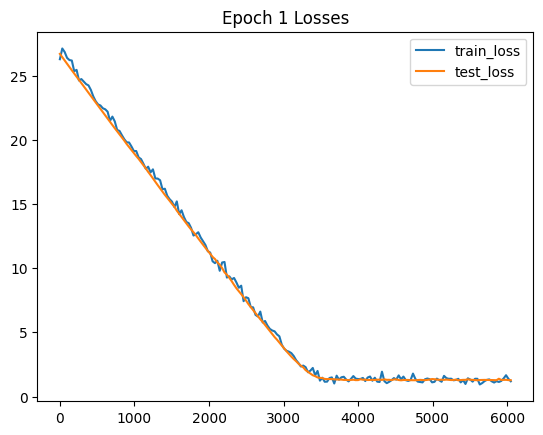

Epoch 1 | Train Loss: 1.1861 | Test Loss: 1.2708


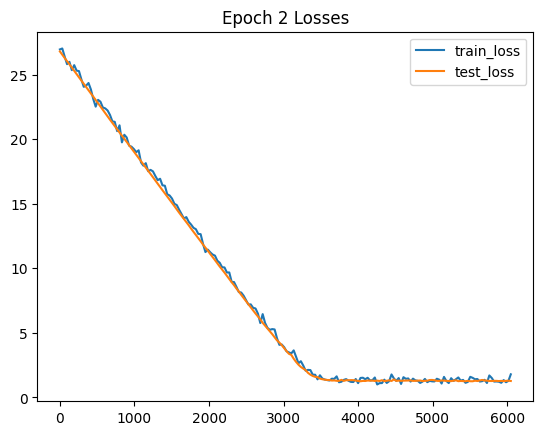

Epoch 2 | Train Loss: 1.7851 | Test Loss: 1.2686


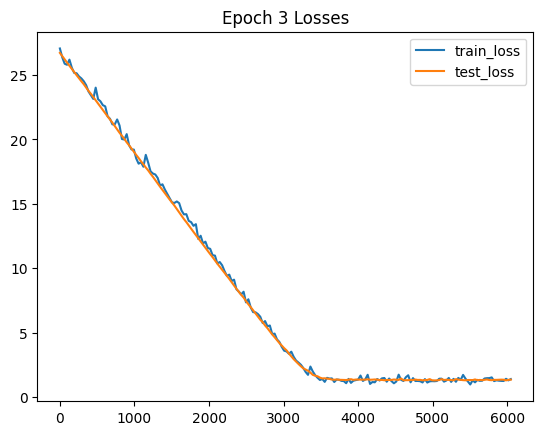

Epoch 3 | Train Loss: 1.3927 | Test Loss: 1.3498


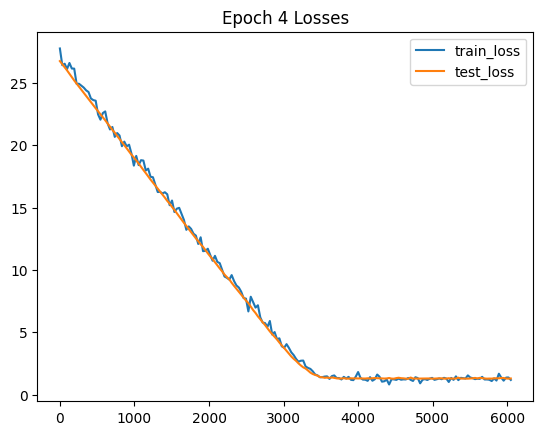

Epoch 4 | Train Loss: 1.1830 | Test Loss: 1.3001


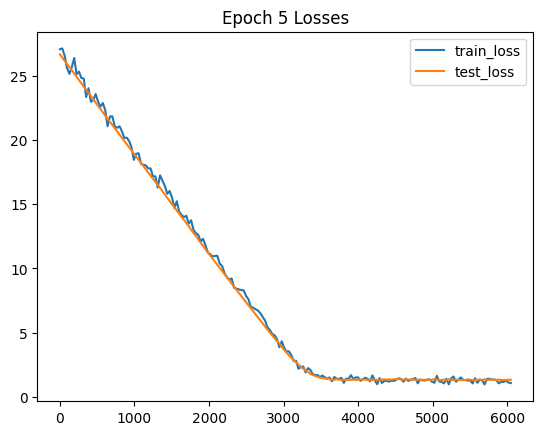

Epoch 5 | Train Loss: 1.0666 | Test Loss: 1.3208


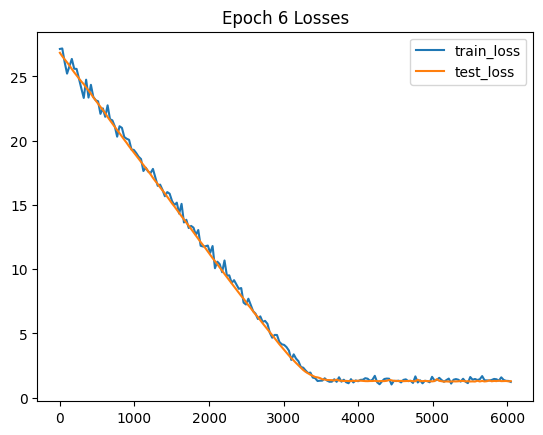

Epoch 6 | Train Loss: 1.2299 | Test Loss: 1.2855


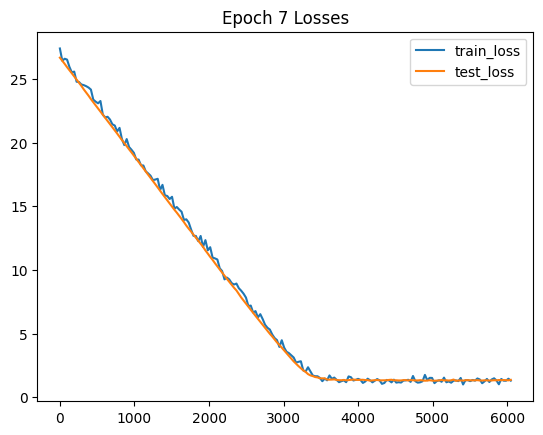

Epoch 7 | Train Loss: 1.2988 | Test Loss: 1.3585


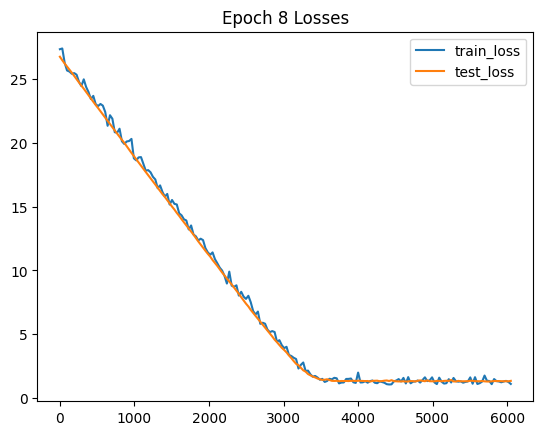

Epoch 8 | Train Loss: 1.0933 | Test Loss: 1.3357


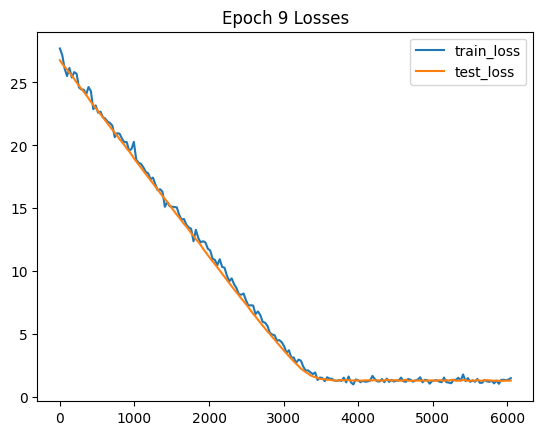

Epoch 9 | Train Loss: 1.4958 | Test Loss: 1.3020


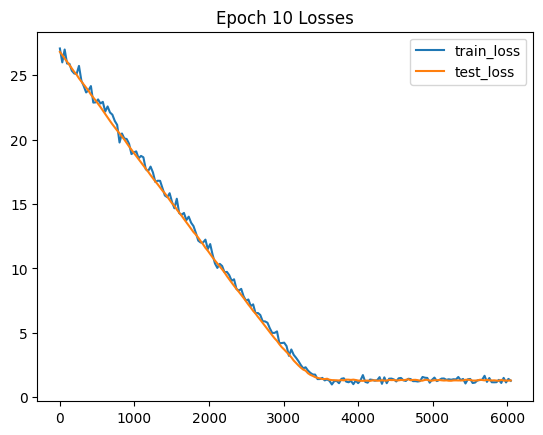

Epoch 10 | Train Loss: 1.2743 | Test Loss: 1.3001


In [5]:
EPOCHS = 10
BATCH_SIZE = 32
for epoch in range(EPOCHS):
	np.random.seed(epoch)
	X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=epoch)
	model = Linear(X.shape[1], Y.shape[1])
	optimizer = Optimizer(model.parameters(), lr=0.25)

	# Training
	losses_train, losses_test = [], []
	for i in range(0, X_train.shape[0], BATCH_SIZE):
		x, y = Tensor(X_train[i:i + BATCH_SIZE]), Tensor(Y_train[i:i + BATCH_SIZE])
		model.enable_grad()
		optimizer.zero_grad()
		y_pred = model(x)
		loss = loss_fn(y_pred, y)
		losses_train.append(loss.x.item())
		loss.backward()
		optimizer.step()

		model.no_grad()
		x, y = Tensor(X_test), Tensor(Y_test)
		y_pred = model(x)
		loss = loss_fn(y_pred, y)
		losses_test.append(loss.x.item())
	plt.plot(np.arange(0, X_train.shape[0], BATCH_SIZE), losses_train, label="train_loss")
	plt.plot(np.arange(0, X_train.shape[0], BATCH_SIZE), losses_test, label="test_loss")
	plt.title(f"Epoch {epoch + 1} Losses")
	plt.legend()
	plt.show()
	print(f"Epoch {epoch + 1} | Train Loss: {losses_train[-1]:.4f} | Test Loss: {losses_test[-1]:.4f}")